## Prepping features dataset


Things to look at:
1. We are currently dropping NA in Demand, Temp. and Humidity. --> Temp and humidity is given each 5 minutes, fill up temp. and humidity with average. 
2. Normalization
3. Demand values we have:
12/31/2018  21:15:00  upandincluding 10/11/2021/ 6:07:00
4. Predicting the demand from 
10/11/2021/ 6:08 upandincluding 12/13/2021  17:59:00 

In [418]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [419]:
def normalize_column(df, columnname):
    """Function which returns a Dataframe where the given column is normalized through min-max normalization."""
    df[f'{columnname}_normalized'] = (df[columnname] - df[columnname].min()) / (df[columnname].max() - df[columnname].min())
    return df.drop([columnname], axis=1)

def add_one_hot_encoder(df, colname):
    """
    Function which returns a DataFrame where the given column has been removed and replaced by
    one-hot-encoding columns for each value in the original column.
    """
    onehot = pd.get_dummies(df[colname], prefix=colname)
    return df.drop(colname, axis=1).join(onehot)

def interpolate_column(df, colname):
    df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')
    return df.drop([colname], axis=1)

In [420]:
import math, datetime, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import itertools
import tqdm
from prophet import Prophet


def load_data(data_path):
  data = pd.read_csv(data_path)  
  return data

In [421]:
#Load in the data
all_data = load_data("train_test_features_df.csv")
print(all_data.shape)
all_data['datetime_local'] = pd.to_datetime(all_data['datetime_local'])
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']

for x in interpolate:
    all_data = interpolate_column(all_data, x)
for x in to_normalize:
    all_data = normalize_column(all_data, x)
for x in add_one_hot_encoding:
    all_data = add_one_hot_encoder(all_data, x)
    
all_data_train = all_data[all_data['datetime_local'] < '2021-10-11 06:08']
all_data_predict = all_data[all_data['datetime_local'] >= '2021-10-11 06:08']
predictions_dates = all_data_predict['datetime_local']
all_data_predict = all_data_predict.drop('datetime_local', axis=1)
all_data_train = interpolate_column(all_data_train, 'demand_kW')
all_data_train = all_data_train.rename(columns={'demand_kW_interpolated': 'demand_kW'})
all_data_predict = all_data_predict.drop('demand_kW', axis=1)

(1552125, 15)


C:\Users\Rob Pennekamp\AppData\Local\Temp\ipykernel_22696\898817105.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')


In [422]:
last_months = all_data_train[all_data_train['datetime_local'] >= '2021-08-11 06:08']
train_data = all_data_train[all_data_train['datetime_local'] < '2021-08-11 06:08']

#Setting date limit:
train_data = train_data[train_data['datetime_local'] >= '2021-01-01 00:00']


train, test = train_test_split(train_data, shuffle=False, test_size=0.1)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train[['datetime_local', 'demand_kW']]
Y_train.index = pd.to_datetime(Y_train['datetime_local'])
Y_train = Y_train.drop('datetime_local', axis=1)

X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test[['datetime_local', 'demand_kW']]
Y_test.index = pd.to_datetime(Y_test['datetime_local'])
Y_test = Y_test.drop('datetime_local', axis=1)

X_lastmonths = last_months.copy().drop(['demand_kW'], axis=1)
Y_lastmonths = last_months[['datetime_local', 'demand_kW']]
Y_lastmonths.index = pd.to_datetime(Y_lastmonths['datetime_local'])
Y_lastmonths = Y_lastmonths.drop('datetime_local', axis=1)

X_train.index = pd.to_datetime(X_train['datetime_local'])
X_train = X_train.drop(['datetime_local'], axis=1)
X_test.index = pd.to_datetime(X_test['datetime_local'])
X_test = X_test.drop(['datetime_local'], axis=1)
X_lastmonths.index = pd.to_datetime(X_lastmonths['datetime_local'])
X_lastmonths = X_lastmonths.drop(['datetime_local'], axis=1)


training_data = [X_train, Y_train, X_test, Y_test, X_lastmonths, Y_lastmonths]
for x in training_data:
    print(x.shape)


(288043, 33)
(288043, 1)
(32005, 33)
(32005, 1)
(87840, 33)
(87840, 1)


# Random Forest

### Parameter settings:

Testing parameters to find the best setting. For a while, the standard settings were best. However, with the inclusion of the frequency of data being another factor, messing around with the model parameters was beneficial.

#### Sampling frequency
Having tested every minute, every 15 minutes, one hour, one day and each week, we've found that every hour is the optimal sampling rate for Random Forest.

#### n_estimators
We've found that, in general, more estimators is better but that it flattens out at ~300 estimators.

#### bootstrap
True is significantly better in combination with all other parameters.

#### loss function
squared error had best performance

#### max_depth
An unlimited amount of depth is better in general, but performance flattens out at a depth of 12 with the amount of features in the final dataframe. For speed, this is set as the limit.

In [302]:
import itertools
import pickle
from datetime import date

def find_optimal_parameters(data, model, params, n_splits=2, verbose=False, freq = 'min'):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        #print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(test_model(current_model,data, freq = freq))
        #results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose, freq = freq))
        #print(results[model_name])
        print(f'Finished testing model.{params_dict} Train RMSE: {results[model_name][1][0]}, Test RMSE: {results[model_name][1][1]}, LastMonths RMSE: {results[model_name][1][2]}')
        if results[model_name][1][2] < lowest:
            lowest = results[model_name][1][2]
            best_model = current_model
            best_model_name = model_name
    try: 
        cur_best = pickle.load(open(f'best_model_{date.today()}.pkl', 'rb'))[1]
        if cur_best > lowest:
            print("New best rmse reached! Pickling model.")
            pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
        else:
            print("RMSE of best model does not improve on the best model of today. Not saving model.")
    except FileNotFoundError:
        print("New best rmse reached! Pickling model.")
        pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
    return results

In [307]:
def test_model(model, data, debug=False, freq = 'min', get_model = False):            
   
    xtrain, ytrain, xtest, ytest, xlastmonths, ylastmonths = data
    
    if freq != 'min':
        xtrain_resampled = xtrain.copy().asfreq(freq, method='ffill')
        ytrain_resampled = ytrain.copy().asfreq(freq, method='ffill')['demand_kW']
    else:
        xtrain_resampled = xtrain.copy()
        ytrain_resampled = ytrain.copy()['demand_kW']
    if debug:
        print("Fitting model...")
    model.fit(xtrain_resampled, ytrain_resampled)
    
    if debug:
        print('Predicting...')
    
    acc_train = model.predict(xtrain_resampled)
    acc_test = model.predict(xtest)
    ytest = ytest['demand_kW']
    acc_lastmonths = model.predict(xlastmonths)
    ylastmonths = ylastmonths['demand_kW']
    if debug:
        print('Calculating rmse...')     
    if get_model:
        print('test:  ', mean_squared_error(list(ytest), acc_test, squared = False), "train:    ", mean_squared_error(list(ytrain), acc_train, squared = False), "month:    ", mean_squared_error(list(lastmonths_Y_test), acc_lastmonths, squared = False))
        return model
    return mean_squared_error(list(ytrain_resampled), acc_train, squared = False), mean_squared_error(list(ytest), acc_test, squared = False), mean_squared_error(list(ylastmonths), acc_lastmonths, squared = False),

In [310]:
model_RF = RandomForestRegressor
RF_parameters = {
    'n_estimators': [300],
    'criterion': ['squared_error'],    
    'max_depth': [12],
    'bootstrap': [True],
    'max_features': [None]
    }
find_optimal_parameters(training_data, model_RF, RF_parameters, freq='h')

[{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None}]
Finished testing model.{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None} Train RMSE: 132.23616003750772, Test RMSE: 391.87185142034775, LastMonths RMSE: 430.4062636873426
New best rmse reached! Pickling model.


{'Model 1': [{'n_estimators': 300,
   'criterion': 'squared_error',
   'max_depth': 12,
   'bootstrap': True,
   'max_features': None},
  (132.23616003750772, 391.87185142034775, 430.4062636873426)]}

In [311]:
GB_parameters = {
    'n_estimators': [700],
    'criterion': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [20]
    }

model_GB = GradientBoostingRegressor

test_GB = find_optimal_parameters(training_data, model_GB, GB_parameters, freq = '1h')

[{'n_estimators': 700, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 20}]
Finished testing model.{'n_estimators': 700, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 20} Train RMSE: 1.4888847792537628e-08, Test RMSE: 561.7772733563354, LastMonths RMSE: 643.0375764343014
RMSE of best model does not improve on the best model of today. Not saving model.


91432
91432 91432


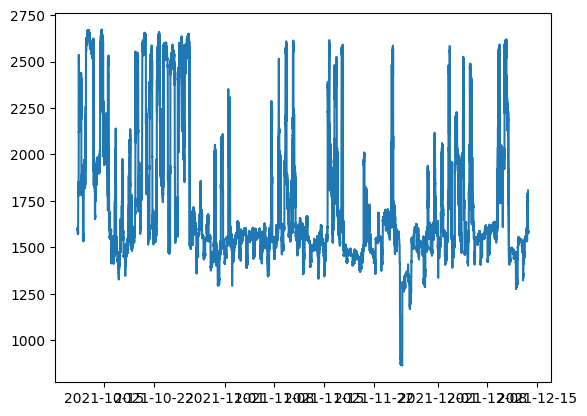

In [423]:
cur_best = pickle.load(open(f'best_model_2023-06-18.pkl', 'rb'))
todays_best = pickle.load(open(f'best_model_{date.today()}.pkl', 'rb'))
print(len(predictions_dates))
test = trainentest.iloc[273988:, :].drop(['demand_kW'], axis=1)


def get_final_predictions(model, data):
    return model.predict(data)
predictions = get_final_predictions(todays_best[0], all_data_predict)
print(len(predictions_dates), len(predictions))
plt.plot(predictions_dates, predictions)
plt.show()


In [427]:
final_pred = pd.DataFrame(predictions_dates, columns = ['datetime_local'])
final_pred['demand_kW'] = predictions
final_pred.to_csv('RF_predictions.csv', index=False)